<a href="https://colab.research.google.com/github/srijalgiri/Assessment_AI/blob/main/2413995_SrijalGiri_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/2413995_SrijalGiri_Assessment/Obesity prediction.csv")


In [13]:
import random
df.loc[df.sample(frac=0.05).index, random.choice(df.columns)] = np.nan
df = pd.concat([df, df.sample(frac=0.1)], ignore_index=True)
df.loc[df['Gender'] == 'Male', 'Gender'] = random.choice(['male', 'MALE', 'M'])

In [14]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
print(duplicate_rows)

Number of duplicate rows: 234
      Gender        Age    Height      Weight family_history FAVC      FCVC  \
98    Female  21.000000  1.520000   42.000000             no   no  3.000000   
106   Female  25.000000  1.570000   55.000000             no  yes  2.000000   
174     MALE  21.000000  1.620000   70.000000             no  yes  2.000000   
184     MALE  21.000000  1.620000   70.000000             no  yes  2.000000   
209   Female  22.000000  1.690000   65.000000            yes  yes  2.000000   
...      ...        ...       ...         ...            ...  ...       ...   
2317  Female  25.951737  1.629442  104.835346            yes  yes  3.000000   
2318  Female  23.000000  1.608469   82.954796            yes  yes  2.150054   
2319    MALE  17.210933  1.819557   58.325122            yes  yes  2.559600   
2320  Female  26.000000  1.627567  107.482662            yes  yes  3.000000   
2321  Female  18.233541  1.792378  137.859737            yes  yes  3.000000   

           NCP       

In [15]:
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [16]:
# Data Cleaning
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)
df.drop_duplicates(inplace=True)
df['Gender'] = df['Gender'].str.lower().map({'male': 'Male', 'female': 'Female'})


In [17]:
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


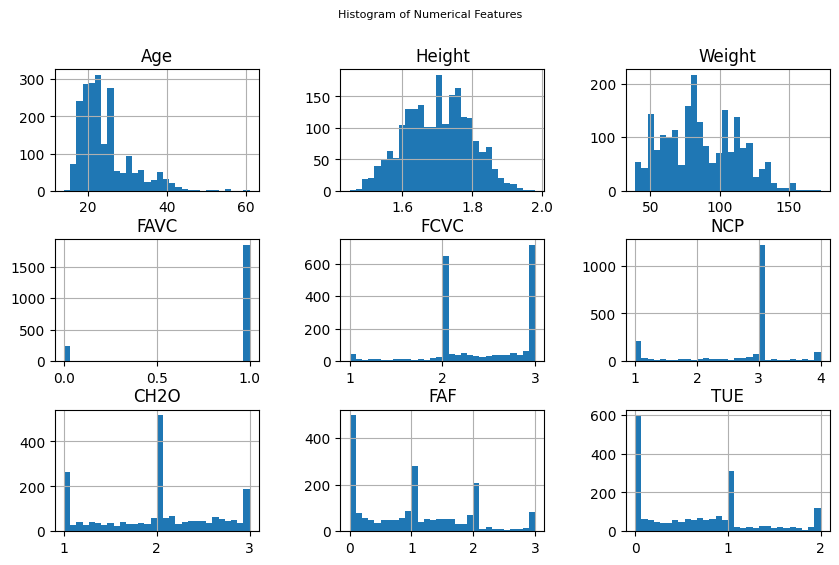

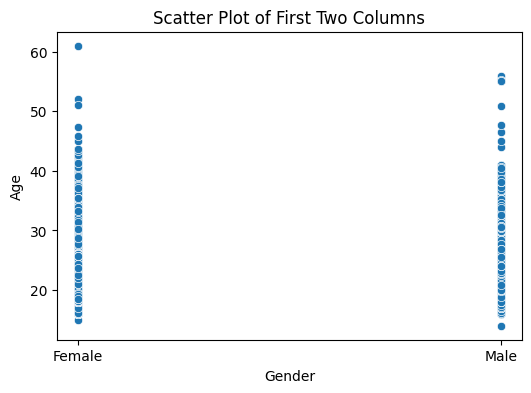

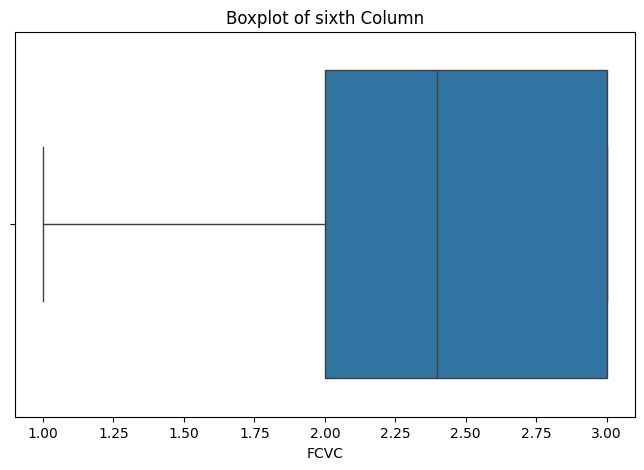

In [32]:
#  Data Visualizations
# Histogram
df.hist(figsize=(10, 6), bins=30)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle("Histogram of Numerical Features", fontsize=8)
plt.show()

# Scatter Plot (Choose two columns to check correlation)
plt.figure(figsize=(6,4))
sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1])
plt.title("Scatter Plot of First Two Columns")
plt.show()

# Boxplot (Detect Outliers for a Specific Column)
plt.figure(figsize=(8,5))
sns.boxplot(x=df.iloc[:, 6])
plt.title("Boxplot of sixth Column")
plt.show()

In [19]:
# Check class distribution for FAVC
favc_distribution = df["FAVC"].value_counts()
print("FAVC Class Distribution:\n", favc_distribution)

FAVC Class Distribution:
 FAVC
yes    1844
no      243
Name: count, dtype: int64


In [20]:
# Encode target variable
df["FAVC"] = df["FAVC"].map({"yes": 1, "no": 0})


In [21]:

X = df.drop(columns=["FAVC"])
y = df["FAVC"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode categorical features only on training set and apply transformation to test set
label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Transform test set
    label_encoders[col] = le

scaler = StandardScaler()
X_train[X_train.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X_train[X_train.select_dtypes(include=[np.number]).columns])
X_test[X_test.select_dtypes(include=[np.number]).columns] = scaler.transform(X_test[X_test.select_dtypes(include=[np.number]).columns])


In [22]:

#Logistic Regression from Scratch
class LogisticRegressionScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = 1 / (1 + np.exp(-linear_model))

            # Gradient descent
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = 1 / (1 + np.exp(-linear_model))
        return (y_predicted > 0.5).astype(int)


In [23]:

# Train Model 1
logistic_model = LogisticRegressionScratch()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

# Build Model 2: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Logistic Regression Results:\n", classification_report(y_test, y_pred_logistic))
print("Confusion Matrix for Logistic Regression:\n", confusion_matrix(y_test, y_pred_logistic))

print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:\n", confusion_matrix(y_test, y_pred_rf))


Logistic Regression Results:
               precision    recall  f1-score   support

           0       0.57      0.08      0.14        49
           1       0.89      0.99      0.94       369

    accuracy                           0.89       418
   macro avg       0.73      0.54      0.54       418
weighted avg       0.85      0.89      0.85       418

Confusion Matrix for Logistic Regression:
 [[  4  45]
 [  3 366]]
Random Forest Results:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59        49
           1       0.93      0.99      0.96       369

    accuracy                           0.93       418
   macro avg       0.89      0.72      0.77       418
weighted avg       0.92      0.93      0.92       418

Confusion Matrix for Random Forest:
 [[ 22  27]
 [  4 365]]


In [24]:

# Hyper-parameter Optimization with Cross-Validation
# Cross-validation for Logistic Regression
logistic_cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
print("Logistic Regression CV Scores:", logistic_cv_scores)

# Hyper-parameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters for Random Forest:", grid_search.best_params_)


Logistic Regression CV Scores: [0.86526946 0.86227545 0.89520958 0.89221557 0.8978979 ]
Best Hyperparameters for Random Forest: {'max_depth': None, 'n_estimators': 50}


In [25]:
# Feature Selection for Logistic Regression
selector = RFE(estimator=LogisticRegression(), n_features_to_select=5)
selector.fit(X_train, y_train)
selected_features_logistic = X_train.columns[selector.support_]
print("Selected Features for Logistic Regression:", selected_features_logistic)

# Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
selected_features_rf = feature_importance_df.sort_values(by="Importance", ascending=False).head(5)["Feature"].tolist()
print("Selected Features for Random Forest:", selected_features_rf)


Selected Features for Logistic Regression: Index(['Weight', 'FAF', 'TUE', 'MTRANS', 'Obesity'], dtype='object')
Selected Features for Random Forest: ['Weight', 'Age', 'Height', 'Obesity', 'FAF']


In [26]:

# Build the Final Model
best_rf_model = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                        max_depth=grid_search.best_params_['max_depth'],
                                        random_state=42)
best_rf_model.fit(X_train[selected_features_rf], y_train)

final_predictions = best_rf_model.predict(X_test[selected_features_rf])
print("Final Model Results:\n", classification_report(y_test, final_predictions))


Final Model Results:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57        49
           1       0.93      0.98      0.95       369

    accuracy                           0.92       418
   macro avg       0.83      0.72      0.76       418
weighted avg       0.91      0.92      0.91       418

